In [21]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Some ETL

In [10]:
data = pd.read_csv("../sample_datasets/sales-forecast-superstore/SuperStore Processed Data.csv")
data['Order Date'] = pd.to_datetime(data['Order Date'],dayfirst=True)
data['Ship Date'] = pd.to_datetime(data['Ship Date'],dayfirst=True)

In [11]:
data.head(2)

,Row ID,Order Date,Ship Date,Order ID,Customer ID,Customer Name,Region,Country,State,City,...,Category,Sub-Category,Product ID,Product Name,Quantity,Payment Mode,Ship Mode,Sales,Profit,Returns
0,454,2020-10-20,2020-10-24,CA-2020-147277,EB-13705,Ed Braxton,East,United States,Ohio,Akron,...,Furniture,Tables,FUR-TA-10001539,Chromcraft Rectangular Conference Tables,2,COD,Standard Class,317.364,-75.8304,0
1,1528,2019-07-22,2019-07-27,CA-2019-122392,CJ-12010,Caroline Jumper,East,United States,Pennsylvania,Allentown,...,Furniture,Furnishings,FUR-FU-10002456,"Master Caster Door Stop, Large Neon Orange",2,COD,Standard Class,11.648,3.3488,0


## Some EDA

In [12]:
data.describe()

,Row ID,Order Date,Ship Date,Quantity,Sales,Profit,Returns
count,5901.000000,5901,5901,5901.000000,5901.000000,5901.000000,5901.000000
mean,5022.422471,2020-02-29 01:53:57.620742144,2020-03-04 00:08:47.097102080,3.781901,265.345589,29.700408,0.048636
min,1.000000,2019-01-01 00:00:00,2019-01-05 00:00:00,1.000000,0.836000,-6599.978000,0.000000
25%,2486.000000,2019-09-11 00:00:00,2019-09-15 00:00:00,2.000000,71.976000,1.795500,0.000000
50%,5091.000000,2020-03-16 00:00:00,2020-03-19 00:00:00,3.000000,128.648000,8.502500,0.000000
75%,7456.000000,2020-09-14 00:00:00,2020-09-16 00:00:00,5.000000,265.170000,28.615000,0.000000
max,9994.000000,2020-12-31 00:00:00,2021-01-05 00:00:00,14.000000,9099.930000,8399.976000,1.000000
std,2877.977184,NaN,NaN,2.212917,474.260645,259.589138,0.215124


In [16]:
categorical_columns = ['Region', 'Country', 'State', 'City', 'Segment', 'Category', 'Sub-Category', 'Payment Mode', 'Ship Mode']
unique_values = {col: data[col].unique() for col in categorical_columns}
unique_values

{'Region': array(['East', 'Central', 'West', 'South'], dtype=object),
 'Country': array(['United States'], dtype=object),
 'State': array(['Ohio', 'Pennsylvania', 'Texas', 'California', 'Massachusetts',
        'Virginia', 'Colorado', 'Georgia', 'Alabama', 'Washington',
        'New York', 'Illinois', 'Maryland', 'Maine', 'New Jersey',
        'Indiana', 'Kentucky', 'Florida', 'Oklahoma', 'North Carolina',
        'Michigan', 'Arizona', 'Tennessee', 'Wyoming', 'South Carolina',
        'New Hampshire', 'Rhode Island', 'Connecticut', 'Iowa', 'Delaware',
        'Utah', 'Wisconsin', 'Oregon', 'New Mexico', 'Arkansas',
        'Nebraska', 'Missouri', 'Mississippi', 'Nevada', 'Louisiana',
        'Idaho', 'Minnesota', 'South Dakota', 'District of Columbia',
        'West Virginia', 'Kansas', 'Vermont', 'North Dakota', 'Montana'],
       dtype=object),
 'City': array(['Akron', 'Allentown', 'Amarillo', 'Anaheim', 'Andover',
        'Apple Valley', 'Arlington', 'Arvada', 'Athens', 'Atlanta',


In [17]:
correlation_matrix = data[['Quantity', 'Sales', 'Profit', 'Returns']].corr()
correlation_matrix

,Quantity,Sales,Profit,Returns
Quantity,1.000000,0.202420,0.074761,0.015877
Sales,0.202420,1.000000,0.325915,0.020288
Profit,0.074761,0.325915,1.000000,0.020988
Returns,0.015877,0.020288,0.020988,1.000000


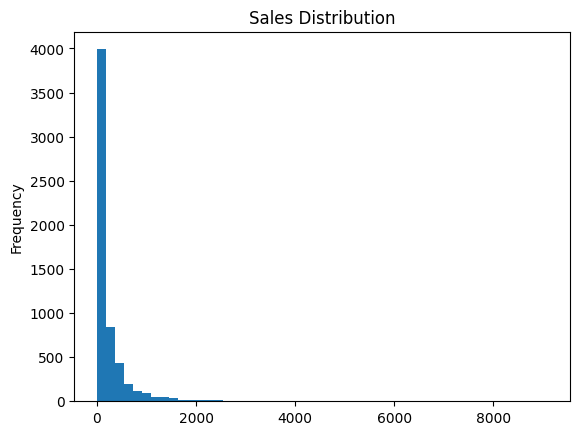

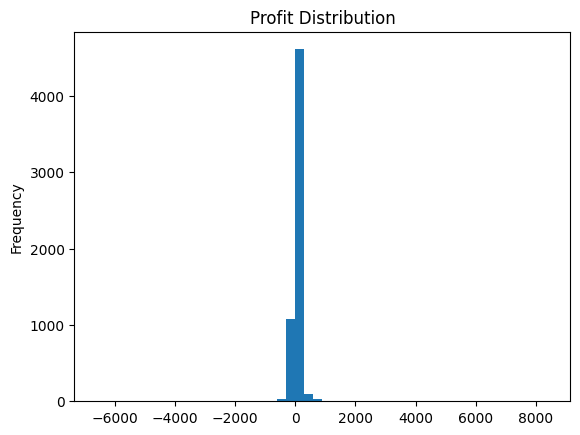

In [18]:
data['Sales'].plot(kind='hist', bins=50, title='Sales Distribution')
plt.show()

data['Profit'].plot(kind='hist', bins=50, title='Profit Distribution')
plt.show()

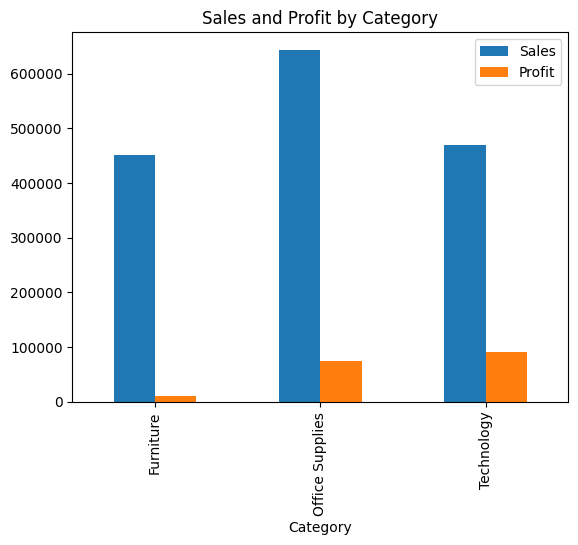

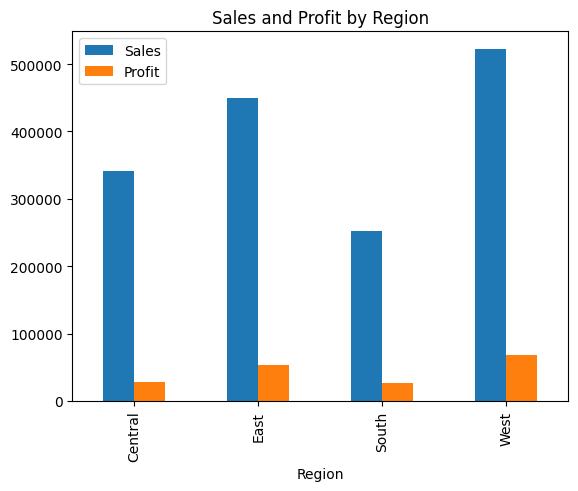

In [23]:
category_summary = data.groupby('Category')[['Sales', 'Profit']].sum()
category_summary.plot(kind='bar', title='Sales and Profit by Category')
plt.show()

region_summary = data.groupby('Region')[['Sales', 'Profit']].sum()
region_summary.plot(kind='bar', title='Sales and Profit by Region')
plt.show()

## Time-series visualizations

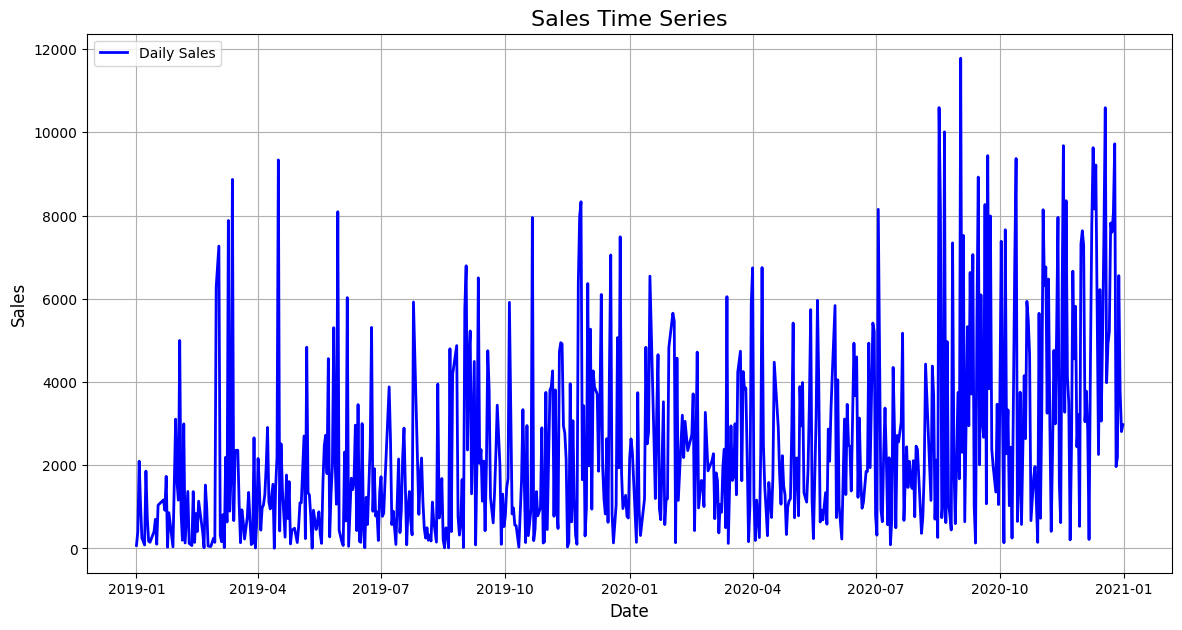

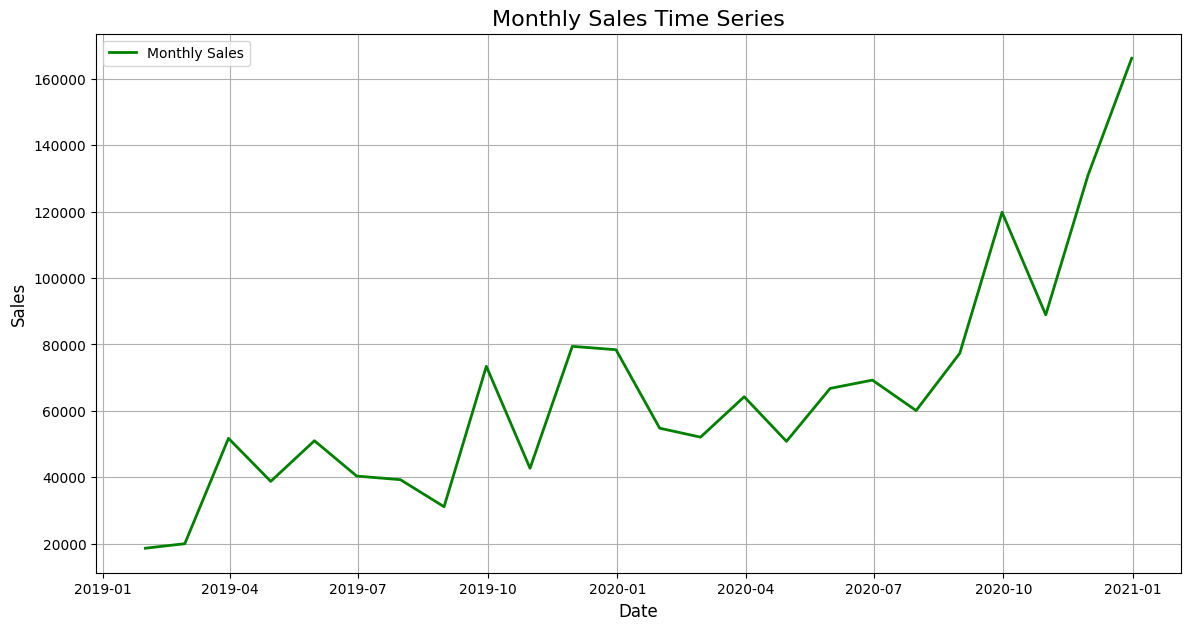

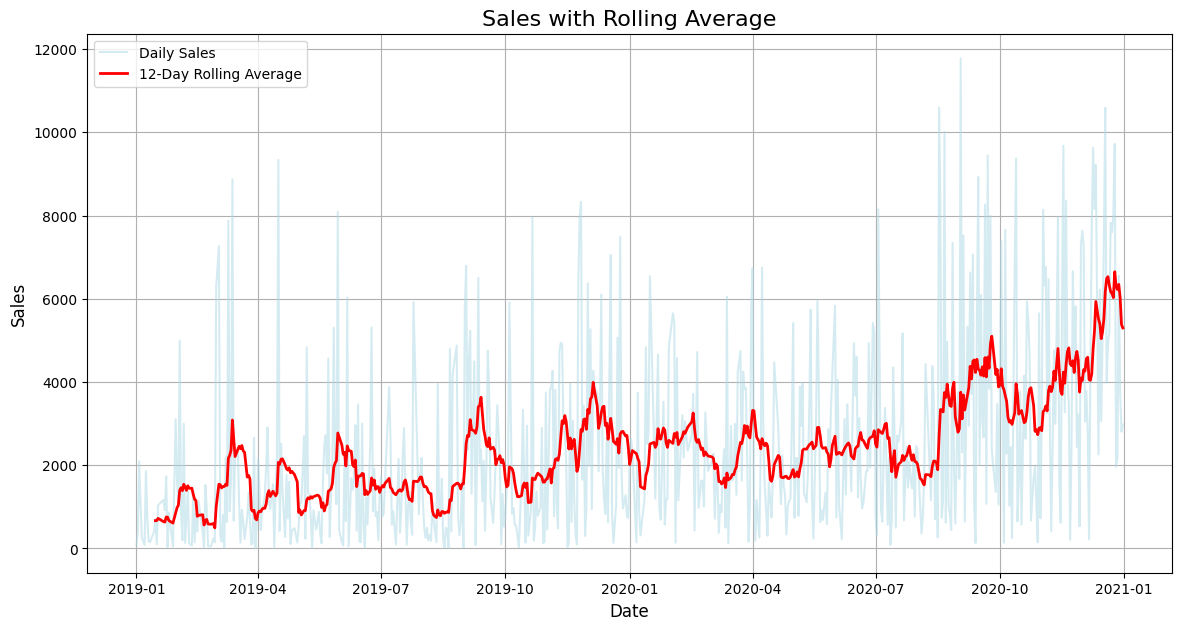

In [15]:
file_path = '../sample_datasets/sales-forecast-superstore/Sales TimeSereis.csv'
sales_timeseries = pd.read_csv(file_path)

# Rename columns for consistency
sales_timeseries.rename(columns={'Order Date': 'Date', 'Sum of Total Sales': 'Sales'}, inplace=True)

# Convert the 'Date' column to datetime
sales_timeseries['Date'] = pd.to_datetime(sales_timeseries['Date'], dayfirst=True)

# Set 'Date' as the index
sales_timeseries.set_index('Date', inplace=True)

# Plot the overall sales trend
plt.figure(figsize=(14, 7))
plt.plot(sales_timeseries.index, sales_timeseries['Sales'], label='Daily Sales', color='blue', linewidth=2)
plt.title('Sales Time Series', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Resample data to monthly sales and plot using 'ME' for month-end frequency
monthly_sales = sales_timeseries['Sales'].resample('ME').sum()

plt.figure(figsize=(14, 7))
plt.plot(monthly_sales.index, monthly_sales, label='Monthly Sales', color='green', linewidth=2)
plt.title('Monthly Sales Time Series', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Plot rolling average (e.g., 12-day window for seasonal trend)
rolling_avg = sales_timeseries['Sales'].rolling(window=12).mean()

plt.figure(figsize=(14, 7))
plt.plot(sales_timeseries.index, sales_timeseries['Sales'], label='Daily Sales', color='lightblue', alpha=0.5)
plt.plot(sales_timeseries.index, rolling_avg, label='12-Day Rolling Average', color='red', linewidth=2)
plt.title('Sales with Rolling Average', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()